## 군집 특성 추론

데이터 로드

In [1]:
import pandas as pd

pca_result = pd.read_csv('./data/minmax_scaling_PCA_label.csv', index_col=0)
scaled_df = pd.read_csv('./data/minmax_scaling.csv', index_col=0)
original_df = pd.read_csv('./data/final_data_after_winsorization.csv', index_col=0)

1. boxplot으로 시각화해서 각 군집의 특성을 추론하기

In [2]:
# 시각화 폰트 깨지는 오류 디버깅
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import os

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

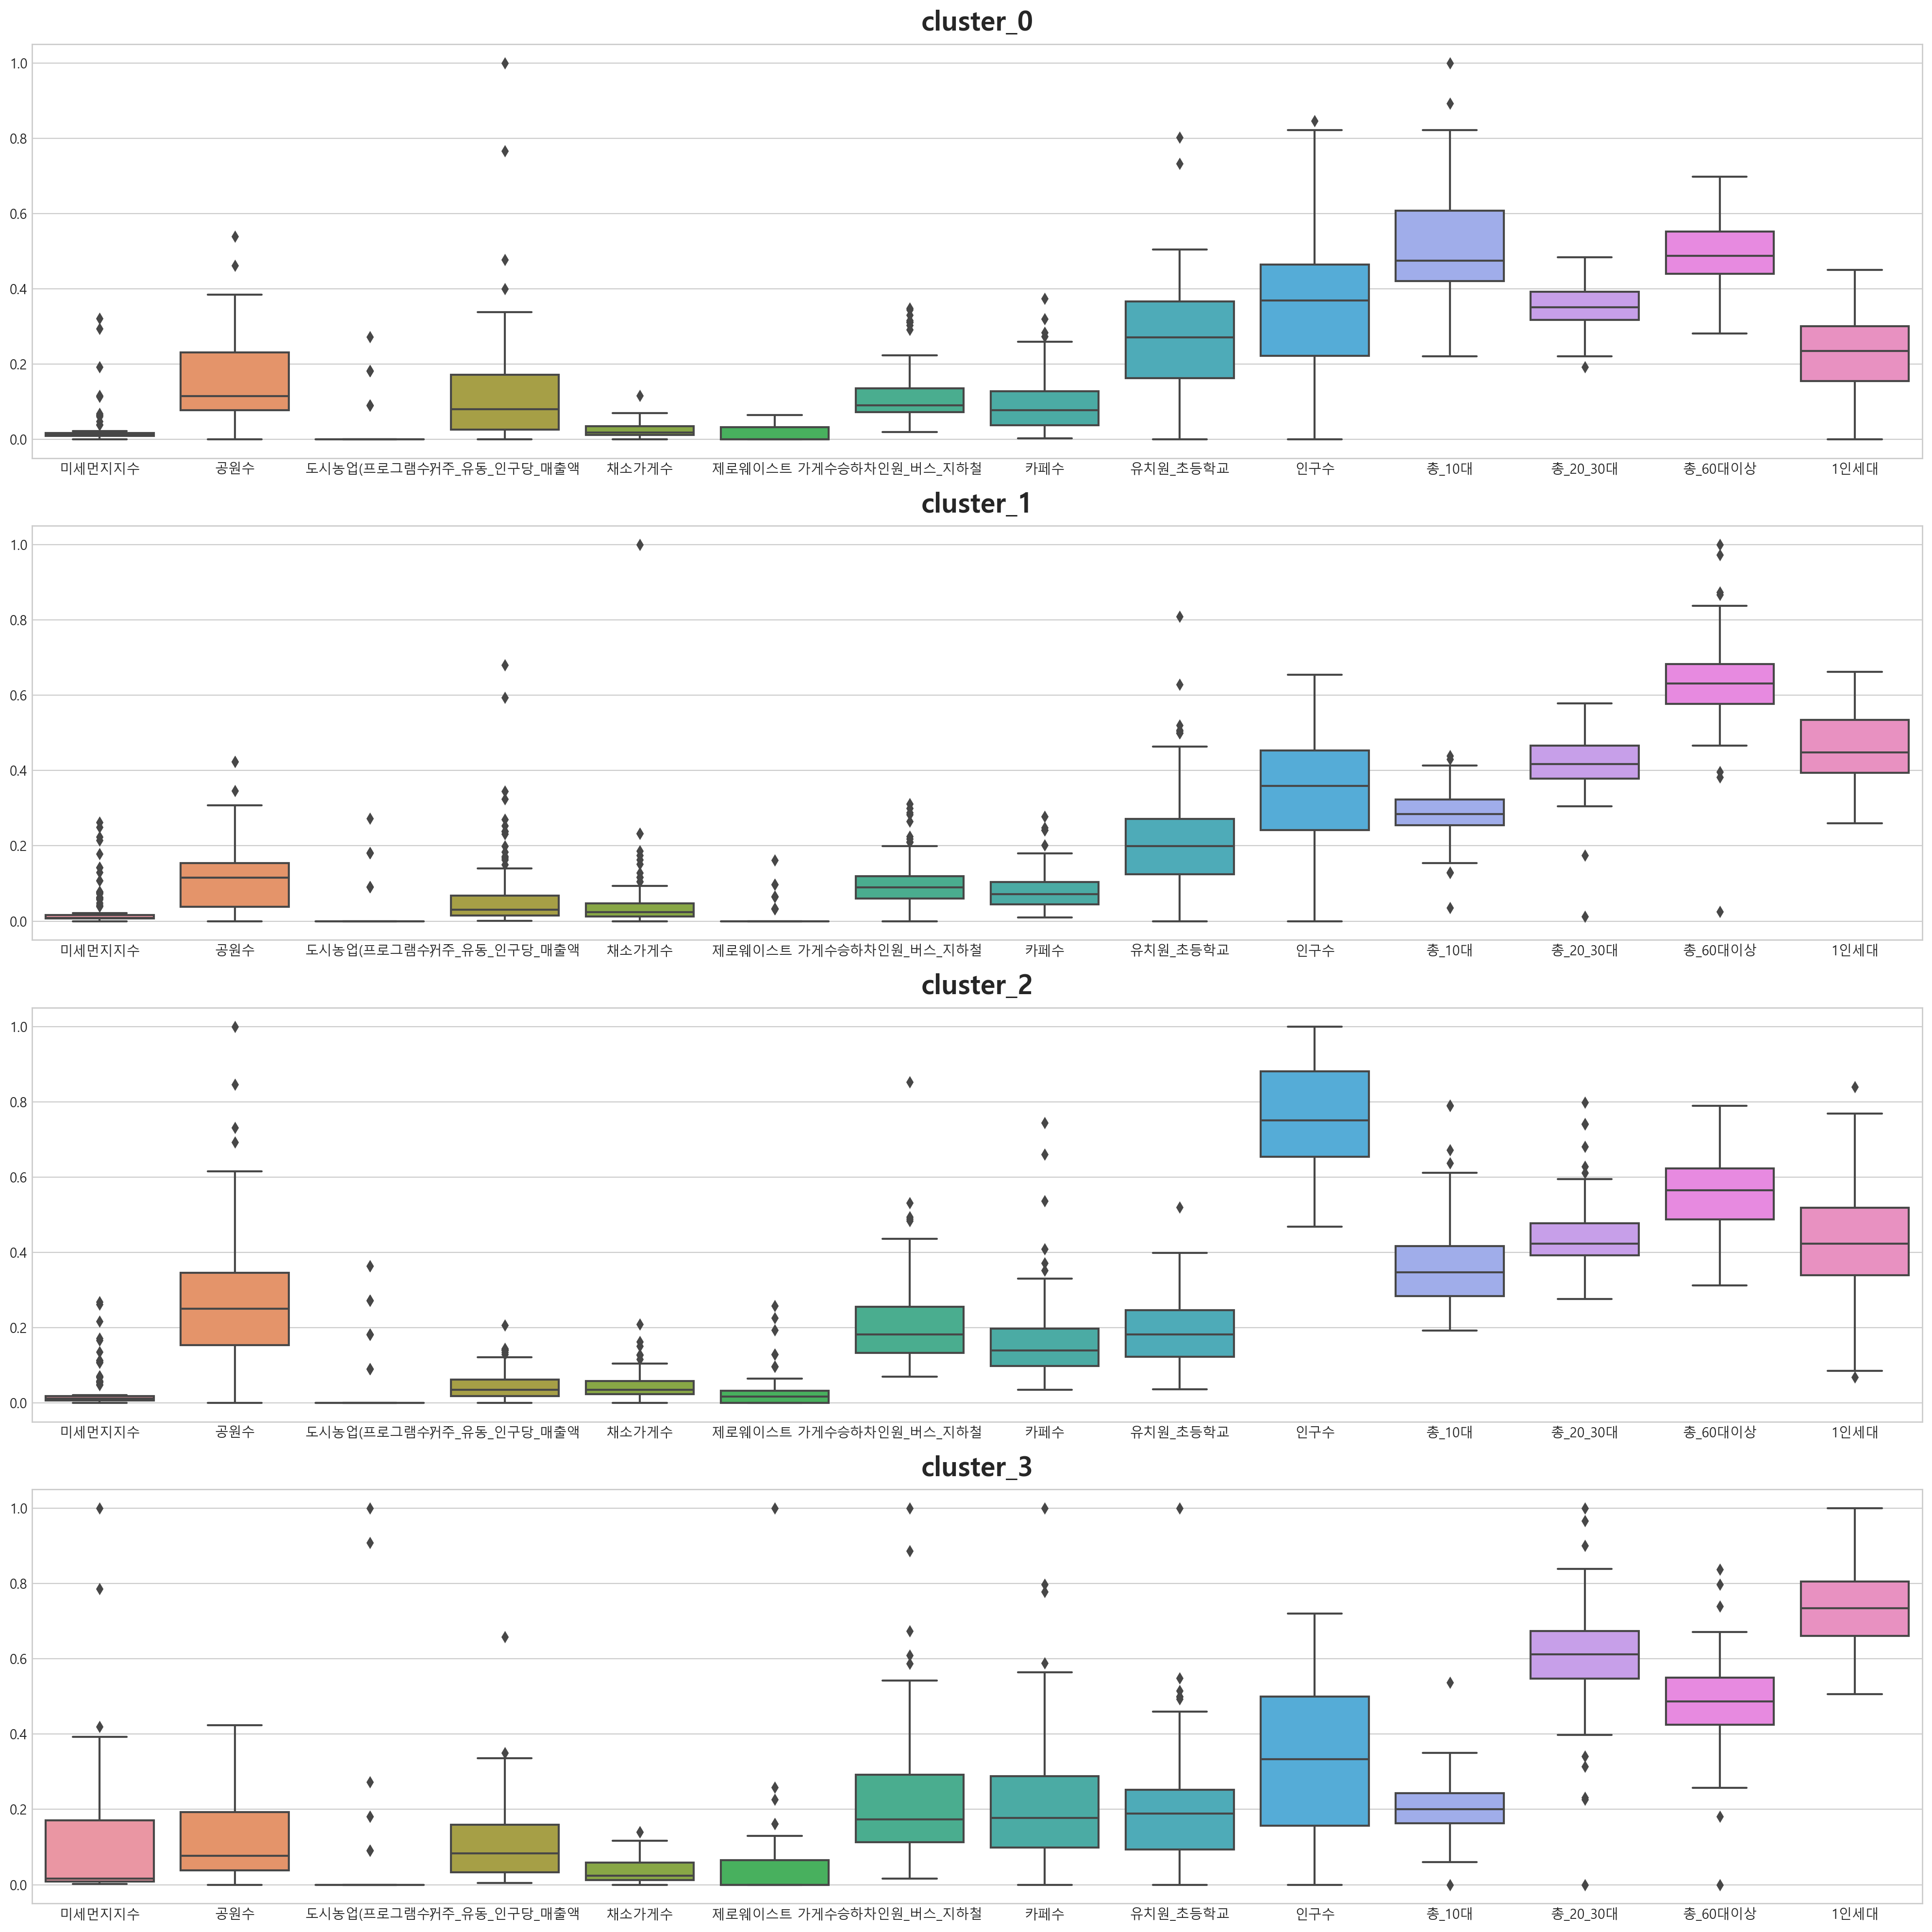

In [3]:
import seaborn as sns

fig , axes = plt.subplots(nrows=4 ,ncols=1,
                          figsize=(20,20) )
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.boxplot(data=scaled_df.loc[pca_result[pca_result['cluster'] == i].index, :], ax = ax[i])
    ax[i].set_title(f"cluster_{i}", fontsize= 20)

plt.show()

2. parallel_coordinates로 시각화해서 각 군집의 특성 추론하기

In [4]:
# minmax scaled data에 클러스터링 레이블 컬럼 추가
scaled_df_label = pd.concat([scaled_df.loc[pca_result[pca_result['cluster'] == i].index, :]
    for i in range(len(pca_result['cluster'].unique()))])

scaled_df_label = scaled_df_label.join(pca_result['cluster'], on='행정동명')
scaled_df_label.sample(3)

미세먼지지수       공원수  도시농업(프로그램수)  거주_유동_인구당_매출액     채소가게수  제로웨이스트 가게수  \
행정동명                                                                          
중곡3동   0.007219  0.000000     0.000000       0.080810  0.058140         0.0   
영등포본동  0.062395  0.076923     0.000000       0.013770  0.011628         0.0   
쌍문1동   0.011449  0.153846     0.090909       0.020511  0.000000         0.0   

       승하차인원_버스_지하철       카페수  유치원_초등학교       인구수     총_10대  총_20_30대  \
행정동명                                                                    
중곡3동       0.057220  0.091133  0.434974  0.314196  0.236529  0.487779   
영등포본동      0.084629  0.110837  0.164733  0.455910  0.241894  0.428558   
쌍문1동       0.120023  0.054187  0.441332  0.453204  0.310738  0.374385   

        총_60대이상      1인세대  cluster  
행정동명                                
중곡3동   0.607883  0.571164        1  
영등포본동  0.643772  0.525274        1  
쌍문1동   0.704091  0.381323        1

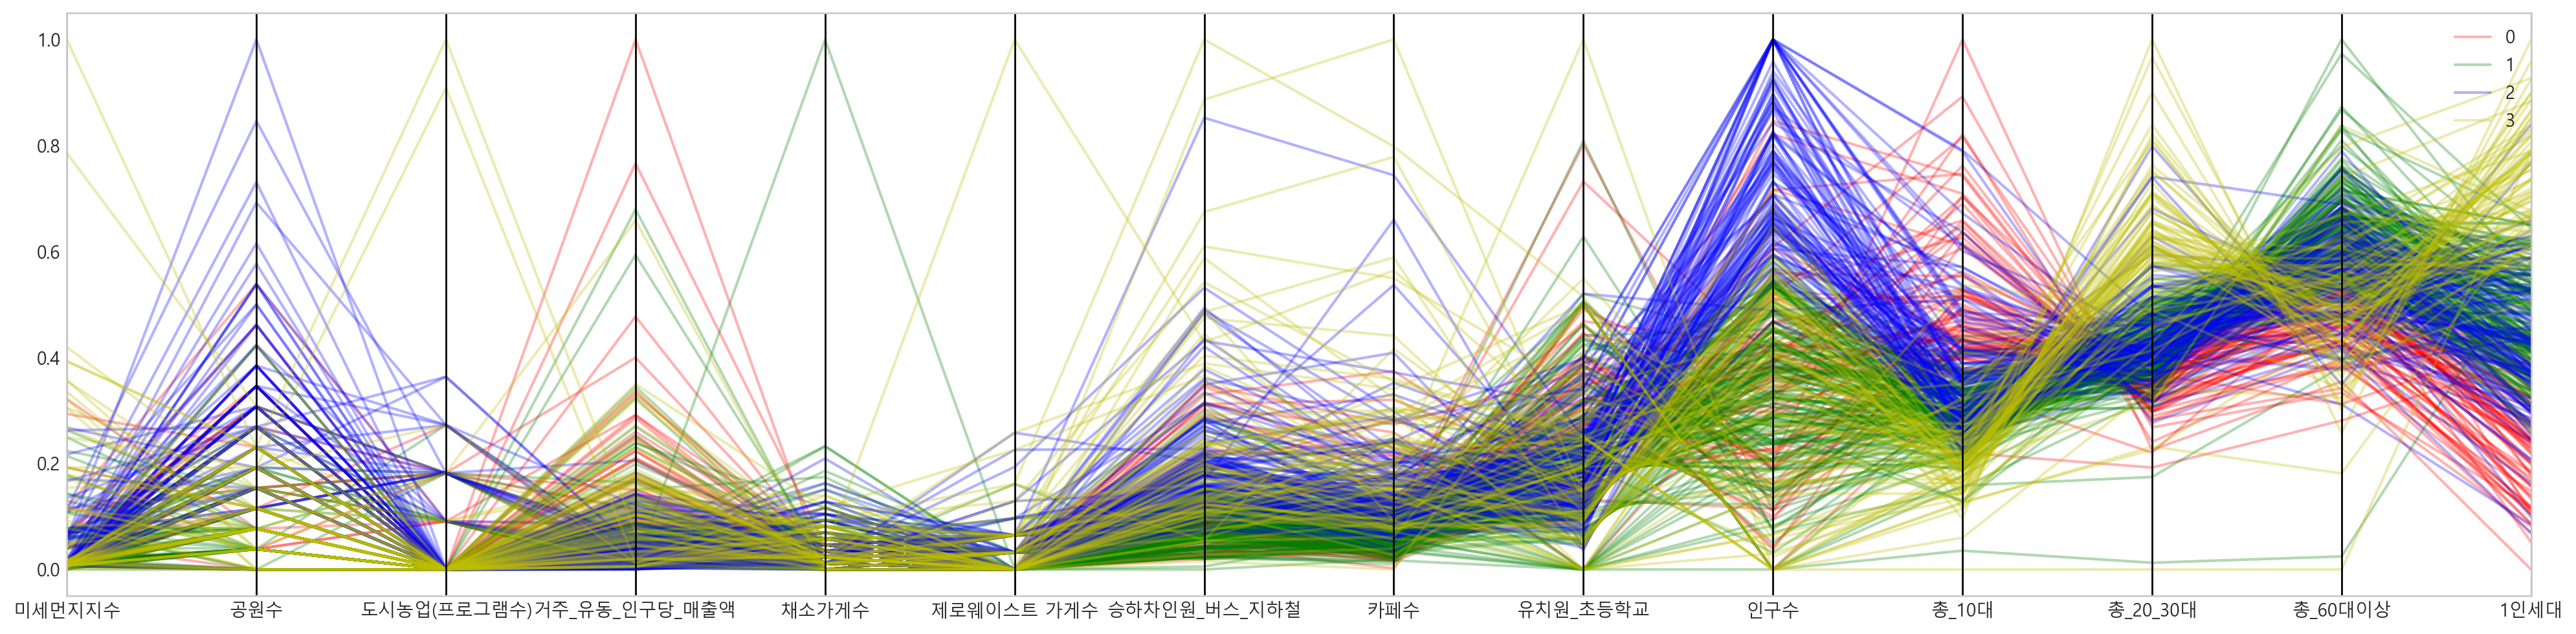

In [5]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(20,5))
parallel_coordinates(scaled_df_label, class_column='cluster', 
                     cols=scaled_df_label.drop('cluster', axis=1).columns, 
                     color=['r', 'g', 'b', 'y'], alpha=0.3)
plt.show()

3. RandomForest 모델링을 통해 군집의 특성 추론하기

-  raw data 활용

In [6]:
# feature selection을 통해 필터링한 컬럼
features = ['미세먼지지수', '공원수', '도시농업(프로그램수)', '거주_유동_인구당_매출액', '채소가게수', '제로웨이스트 가게수',
       '승하차인원_버스_지하철', '카페수', '유치원_초등학교', '인구수', '총_10대', '총_20_30대',
       '총_60대이상', '1인세대']

In [7]:
# original data에 클러스터링 레이블 컬럼 추가
original_df_label = pd.concat([original_df.loc[pca_result[pca_result['cluster'] == i].index, :]
    for i in range(len(pca_result['cluster'].unique()))])

original_df_label = original_df_label[features]
original_df_label = original_df_label.join(pca_result['cluster'], on='행정동명')
original_df_label.sample(3)

미세먼지지수  공원수  도시농업(프로그램수)  거주_유동_인구당_매출액  채소가게수  제로웨이스트 가게수  \
행정동명                                                                
시흥1동   14.245    6          2.0      63.812587   14.0         1.0   
남가좌1동  13.844    4          0.0       8.672740    6.0         0.0   
송중동    13.848    5          0.0      19.716065    3.0         1.0   

       승하차인원_버스_지하철   카페수  유치원_초등학교    인구수     총_10대  총_20_30대   총_60대이상  \
행정동명                                                                       
시흥1동       654533.0  72.0  0.000062  64634  0.063001  0.286784  0.294860   
남가좌1동      193231.0  17.0  0.000060  33446  0.108892  0.228906  0.195898   
송중동        955265.0  81.0  0.000103  57984  0.064845  0.266798  0.304877   

           1인세대  cluster  
행정동명                      
시흥1동   0.484752        2  
남가좌1동  0.223485        0  
송중동    0.452244        2

In [8]:
# randomforest classification을 위한 데이터 준비
original_df_label['binary_cluster_0'] = original_df_label['cluster'].map({0:1, 1:0, 2:0, 3:0})
original_df_label['binary_cluster_1'] = original_df_label['cluster'].map({0:0, 1:1, 2:0, 3:0})
original_df_label['binary_cluster_2'] = original_df_label['cluster'].map({0:0, 1:0, 2:1, 3:0})
original_df_label['binary_cluster_3'] = original_df_label['cluster'].map({0:0, 1:0, 2:0, 3:1})
original_df_label.sample(3)

미세먼지지수  공원수  도시농업(프로그램수)  거주_유동_인구당_매출액  채소가게수  제로웨이스트 가게수  \
행정동명                                                                 
중계2.3동  14.719    6          0.0      57.328435    0.0         0.0   
상계2동    14.719    0          0.0     239.523296    7.0         1.0   
중화2동    15.673    5          0.0      21.356962    5.0         0.0   

        승하차인원_버스_지하철    카페수  유치원_초등학교    인구수     총_10대  총_20_30대   총_60대이상  \
행정동명                                                                         
중계2.3동      297539.0   31.0  0.000137  65870  0.083559  0.233278  0.315227   
상계2동        419371.0  113.0  0.000103  38810  0.085493  0.265241  0.281525   
중화2동        274139.0   33.0  0.000041  48392  0.042280  0.289924  0.322119   

            1인세대  cluster  binary_cluster_0  binary_cluster_1  \
행정동명                                                            
중계2.3동  0.369599        2                 0                 0   
상계2동    0.398998        1                 0                 1   
중화2동    0.556148        1                 0                 1   

        binary_cluster_2  binary_cluster_3  
행정동명                                        
중계2.3동                 1                 0  
상계2동                   0                 0  
중화2동                   0                 0

In [9]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def check_feature_importance(df, col):
    clf = RandomForestClassifier(random_state=1)
    clf.fit(df.iloc[:, :-5].values, df[col].values)

    # 가장 중요한 피처의 인덱스 구하기
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

    # 가장 중요한 피처의 이름과 weight 구하기
    most_important_features = np.take_along_axis(
        np.array(df.iloc[:, 0:-1].columns.tolist()), 
        sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(
        np.array(clf.feature_importances_), 
        sorted_feature_weight_idxes, axis=0)

    result = list(zip(most_important_features, most_important_weights))
    return pd.DataFrame(index=most_important_features, data=most_important_weights, columns=['feature importance'])

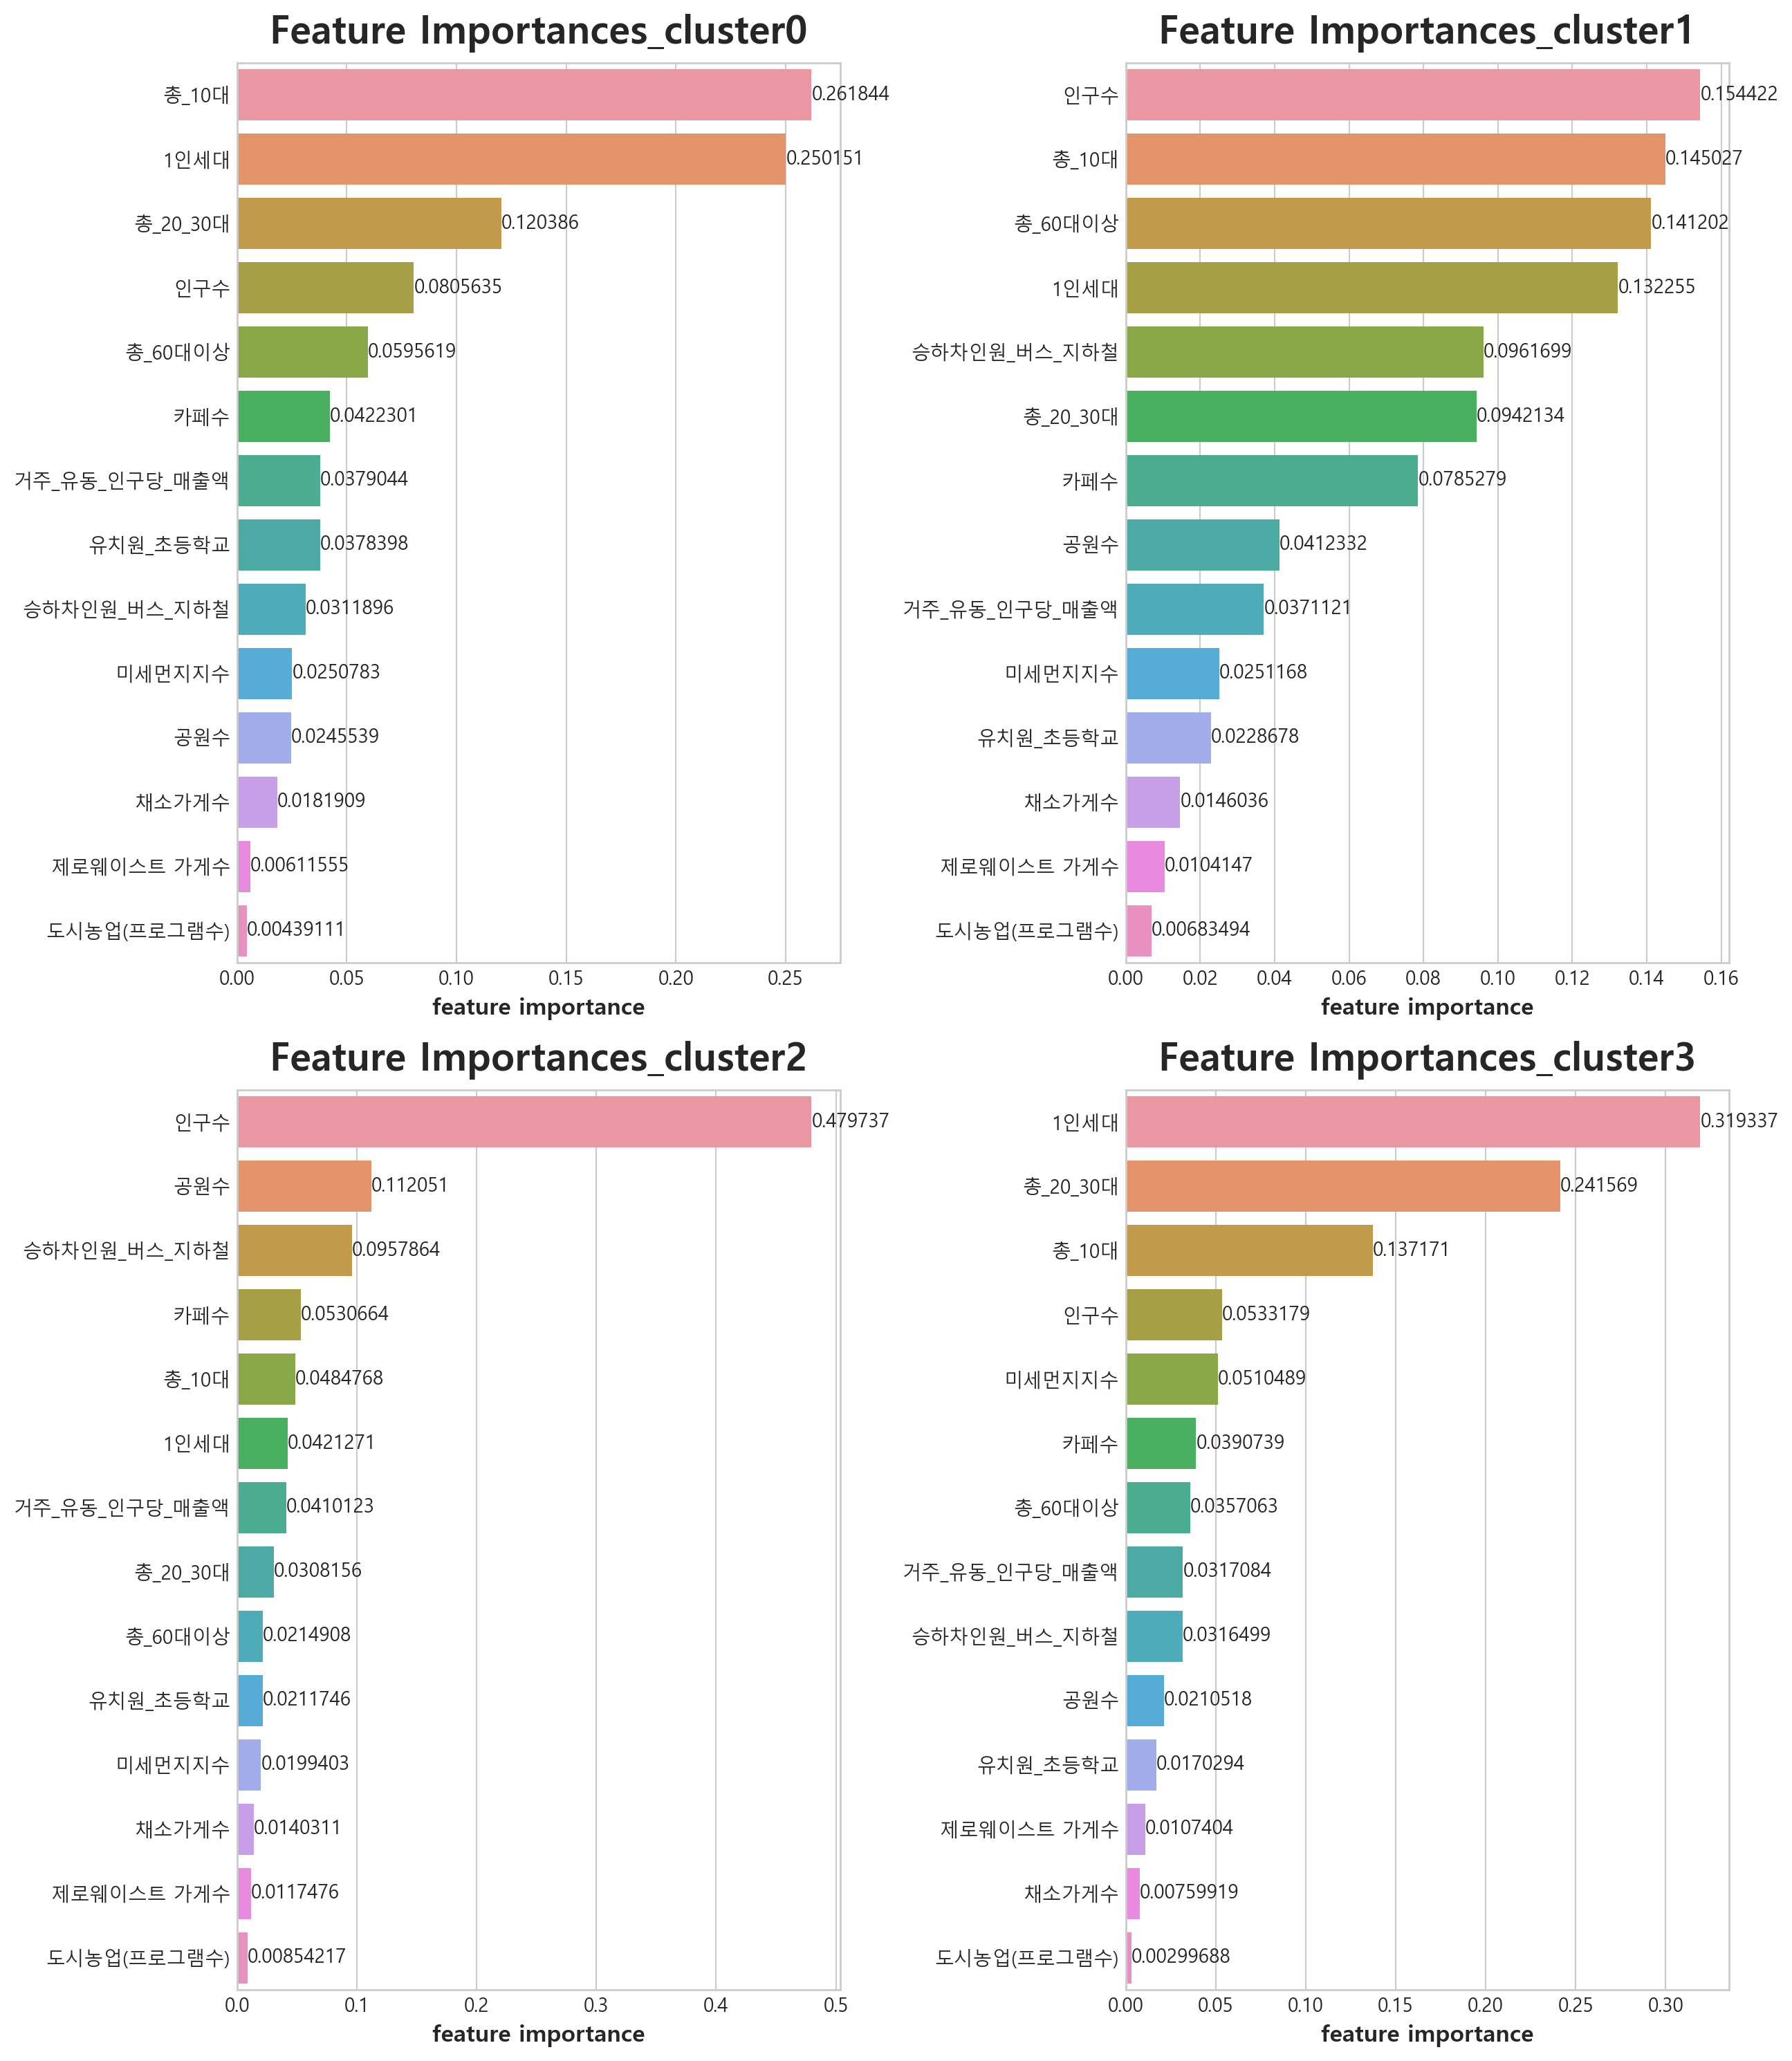

In [13]:
fig, axes = plt.subplots(nrows=2 ,ncols=2,
                          figsize=(13,15))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.barplot(x=check_feature_importance(original_df_label, f'binary_cluster_{i}')['feature importance'], 
            y=check_feature_importance(original_df_label, f'binary_cluster_{i}').index, ax=ax[i])
    ax[i].set_title(f"Feature Importances_cluster{i}", fontsize= 20)
    ax[i].bar_label(ax[i].containers[0], fontsize=10);

plt.show()

- minmax scaled data 활용

In [11]:
# randomforest classification을 위한 데이터 준비
scaled_df_label['binary_cluster_0'] = scaled_df_label['cluster'].map({0:1, 1:0, 2:0, 3:0})
scaled_df_label['binary_cluster_1'] = scaled_df_label['cluster'].map({0:0, 1:1, 2:0, 3:0})
scaled_df_label['binary_cluster_2'] = scaled_df_label['cluster'].map({0:0, 1:0, 2:1, 3:0})
scaled_df_label['binary_cluster_3'] = scaled_df_label['cluster'].map({0:0, 1:0, 2:0, 3:1})
scaled_df_label.sample(3)

미세먼지지수       공원수  도시농업(프로그램수)  거주_유동_인구당_매출액     채소가게수  제로웨이스트 가게수  \
행정동명                                                                         
월계1동  0.006029  0.230769     0.000000       0.076629  0.011628    0.032258   
광장동   0.008690  0.038462     0.090909       0.054772  0.011628    0.000000   
명동    0.785713  0.307692     0.000000       0.163768  0.034884    1.000000   

      승하차인원_버스_지하철       카페수  유치원_초등학교       인구수     총_10대  총_20_30대  \
행정동명                                                                   
월계1동      0.184507  0.110837  0.165873  0.451893  0.326310  0.436552   
광장동       0.073782  0.135468  0.270286  0.821212  0.708941  0.316065   
명동        0.428661  0.564039  0.250000  0.000000  0.127116  0.226053   

       총_60대이상      1인세대  cluster  binary_cluster_0  binary_cluster_1  \
행정동명                                                                    
월계1동  0.629355  0.493549        1                 0                 1   
광장동   0.382322  0.147498        0                 1                 0   
명동    0.455297  0.794360        3                 0                 0   

      binary_cluster_2  binary_cluster_3  
행정동명                                      
월계1동                 0                 0  
광장동                  0                 0  
명동                   0                 1

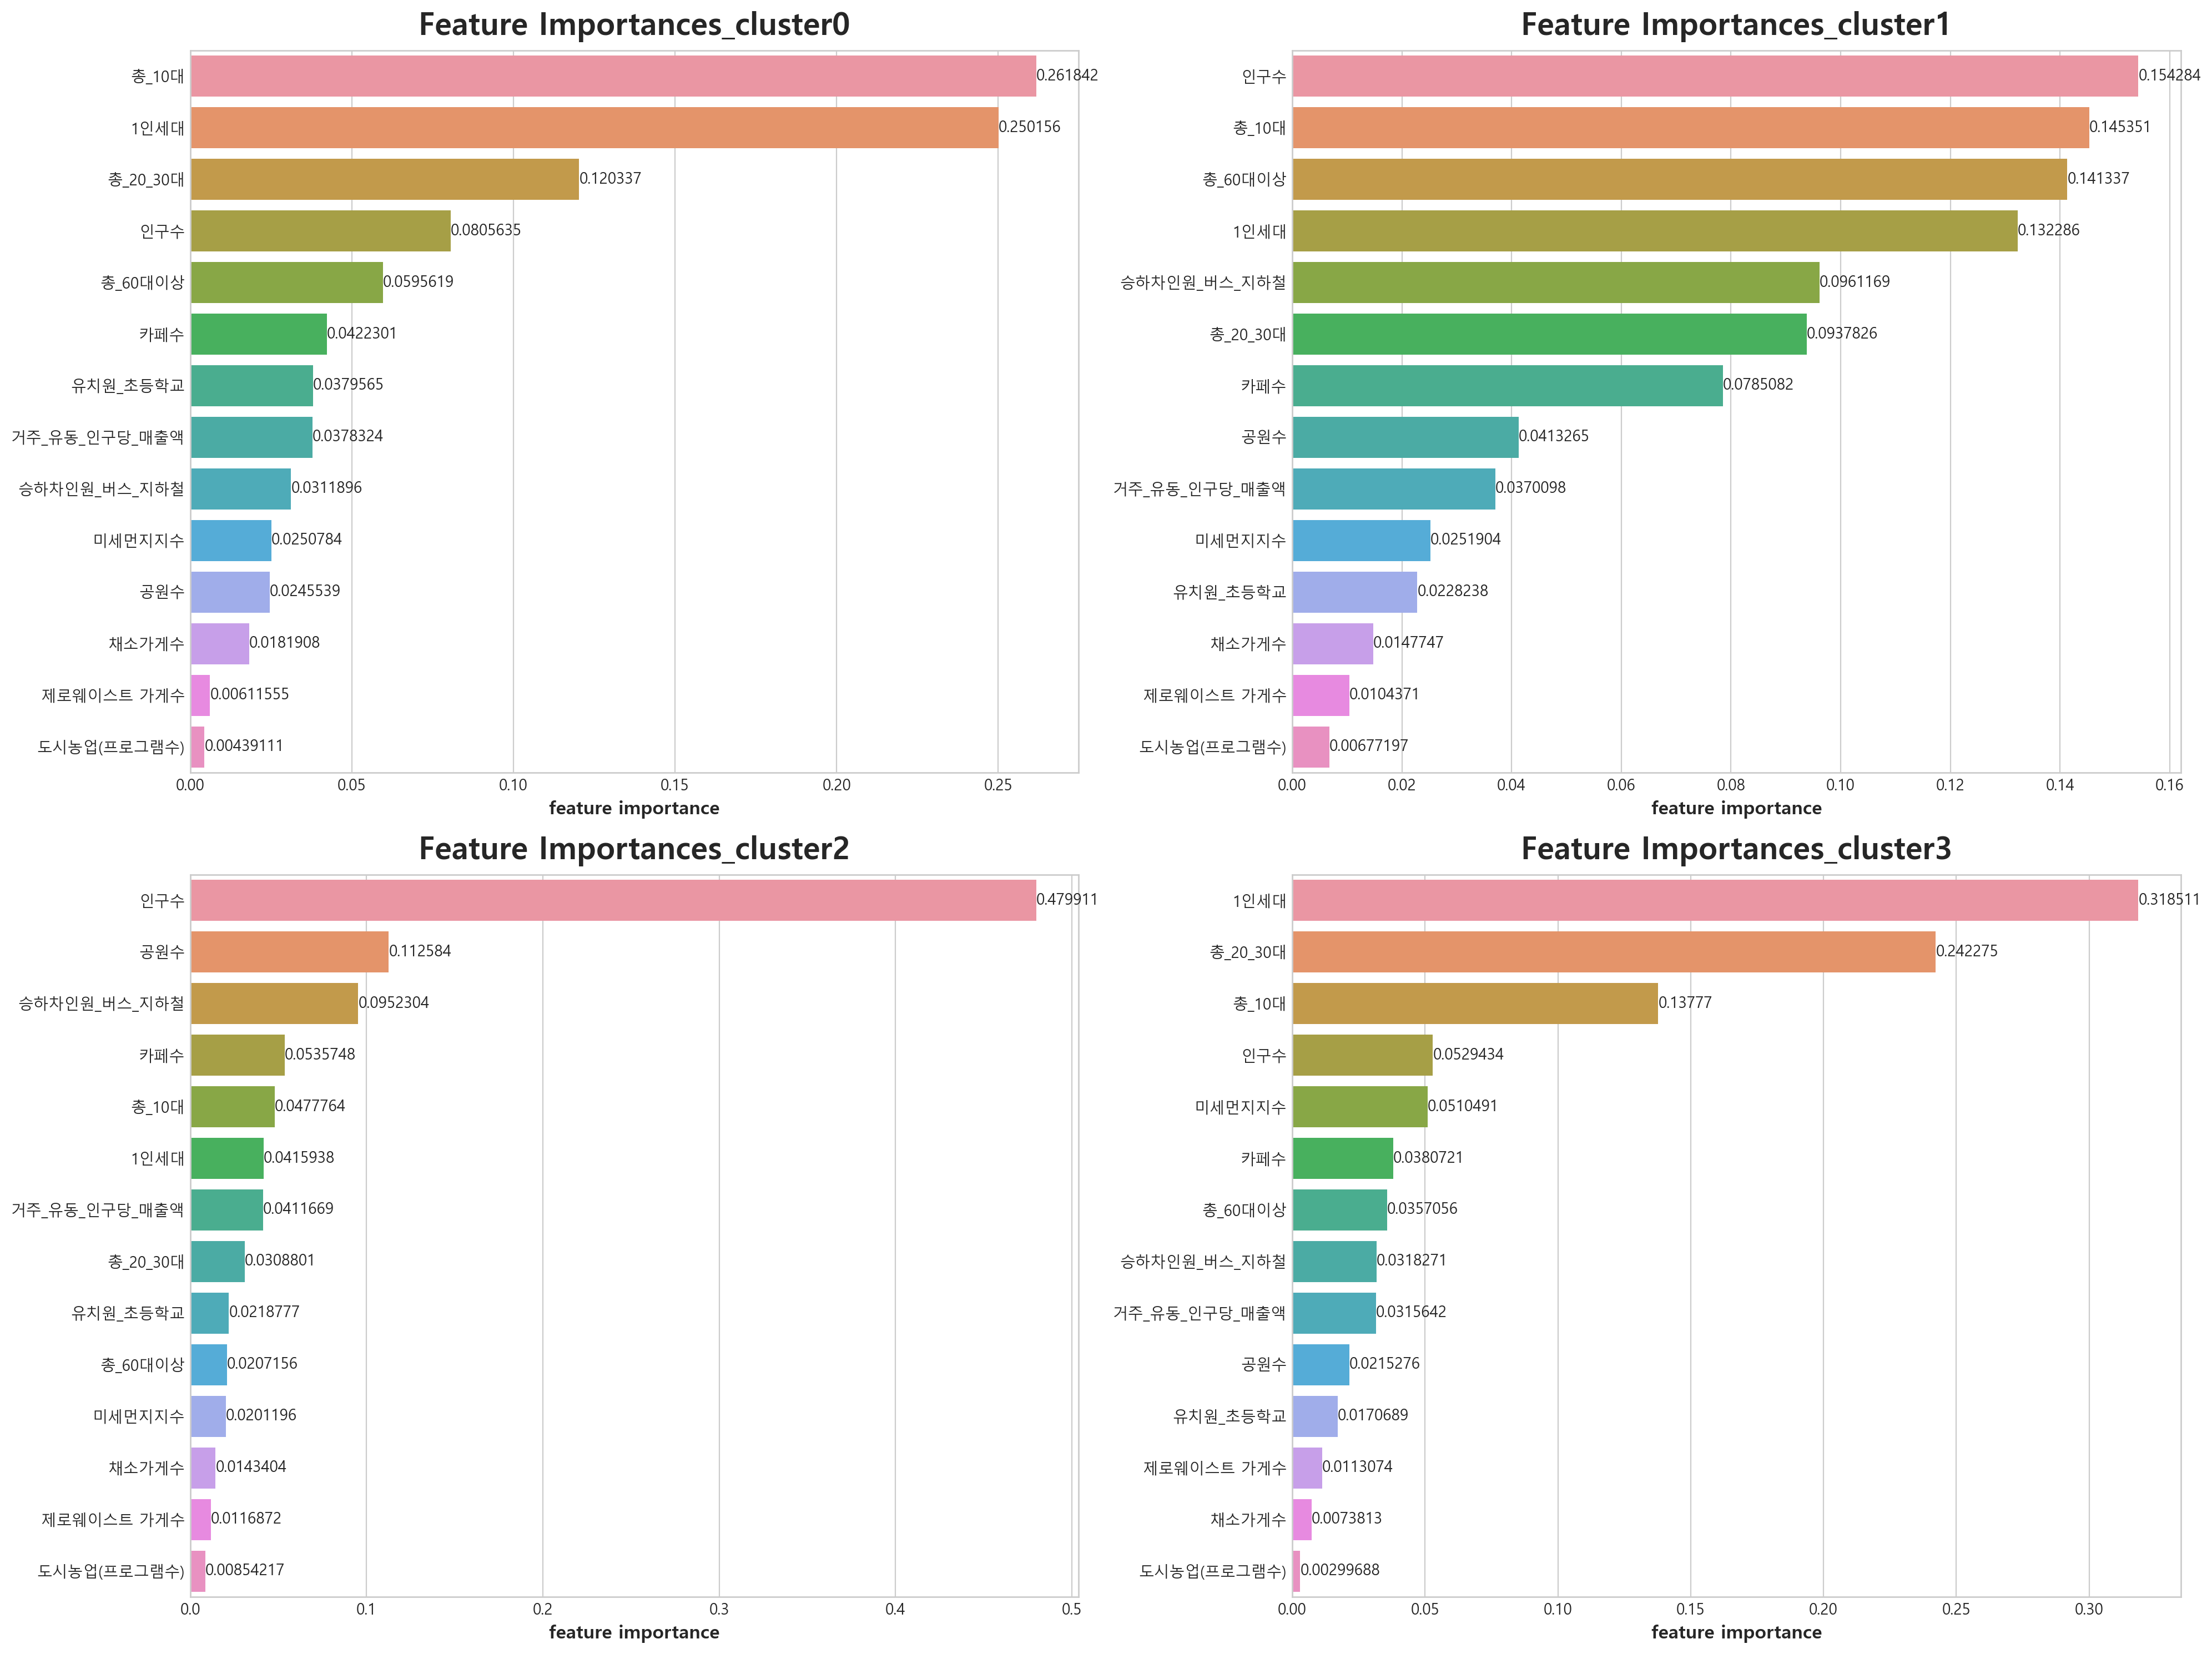

In [12]:
fig, axes = plt.subplots(nrows=2 ,ncols=2,
                          figsize=(20,15))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axes.flatten()

for i in range(len(pca_result['cluster'].unique())):
    sns.barplot(x=check_feature_importance(scaled_df_label, f'binary_cluster_{i}')['feature importance'], 
            y=check_feature_importance(scaled_df_label, f'binary_cluster_{i}').index, ax=ax[i])
    ax[i].set_title(f"Feature Importances_cluster{i}", fontsize= 20)
    ax[i].bar_label(ax[i].containers[0], fontsize=10);

plt.show()